<a href="https://colab.research.google.com/github/inuwamobarak/Image-captioning-ViT/blob/main/Image_Captioning_using_Transformer_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

Image captioning involves translating an image into a textual description. We use Vision Transformers (ViT) and PyTorch backend. The article and code demonstrates using trained models without retraining from scratch to generate image captions.

# Importing Required Libraries

In [ ]:
# Installing Transformer Libraries
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-z54jw3lg
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-z54jw3lg
  Resolved https://github.com/huggingface/transformers to commit 34a640642be61e0e2eb622e497140be3aea202bc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.5 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.35.0.dev0-py3-none-any.whl size=7881983 sha256=4c079537821e73667b301406d0d6e10d729fdb363372609fbe3cf5e71fb7acca
  Stored in directory: /tmp/pip-ephem-wheel-cache-xr7y

In [ ]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 5.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.executable


'/usr/bin/python3'

In [ ]:
# Web links Handler
import requests

# Backend
import torch

# Image Processing
from PIL import Image

# Transformer and Pretrained Model
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2TokenizerFast, AutoTokenizer, Trainer, TrainingArguments
import pickle

# Managing loading processsing
from tqdm import tqdm

# Assign available GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

import pickle
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
device = torch.device("mps")

In [ ]:
torch.mps.empty_cache()

# Using a Trained Model

In [ ]:
# Loading a fine-tuned image captioning Transformer Model

# ViT Encoder - Decoder Model
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
print(device)

cuda


In [ ]:
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+

False


In [ ]:
print(torch.backends.mps.is_built()) #MPS is activated

In [ ]:
# Load the preprocessed data from the pickle file
with open('/content/preprocessed_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Now you can work with the loaded_data, which contains your serialized tensors

In [ ]:
# Split the dataset into training and test sets
train_data, test_data = train_test_split(loaded_data, test_size=0.25, random_state=42)

type(loaded_data)

list

In [ ]:
# Corresponding ViT Tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Image processor
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [ ]:
#entry = loaded_data[0]
#pixel_values = pickle.loads(entry['pixel_values'])
#pixel_values.shape

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, loaded_data, model):
        self.loaded_data = loaded_data
        self.tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

    def __len__(self):
        return len(self.loaded_data)

    def __getitem__(self, idx):
        entry = loaded_data[idx]
        pixel_values = pickle.loads(entry['pixel_values'])  # Deserialize the tensor
        # Define the transformation to resize the tensor
        pixel_values = pixel_values.squeeze(0)
        resize = transforms.Compose([
            transforms.ToPILImage(),  # Convert the tensor to a PIL image
            transforms.Resize((224, 224)),  # Resize to the desired size (e.g., 224x224)
            transforms.ToTensor()  # Convert the PIL image back to a tensor
        ])
        pixel_values=resize(pixel_values)
        pixel_values = pixel_values.to(device)

        # Tokenize the description
        description = entry['description']
        labels = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")(description, return_tensors='pt', padding=True, truncation=True, max_length=64)
        input_ids = labels.input_ids
        attention_mask = labels.attention_mask

        return {
            'pixel_values': pixel_values,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
        }


In [ ]:
# Initialize your custom dataset for training
train_dataset = CustomDataset(train_data, model)
test_dataset = CustomDataset(test_data, model)

#entry = train_dataset[1000]
#entry['pixel_values'].shape

In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    evaluation_strategy="steps",  # Evaluate at the end of each epoch
    save_total_limit=3,  # Limit the total number of checkpoints
    save_steps=500,  # Save a checkpoint every 500 steps
    eval_steps=500,  # Evaluate every 500 steps
    logging_steps=100,  # Log every 100 steps
    learning_rate=1e-5,
)

# Initialize a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # Provide a test dataset for evaluation
)


In [ ]:
# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
model.load_state_dict(torch.load("/content/checkpoint_1.pth"))

<All keys matched successfully>

In [ ]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    model.train()
    total_loss = 0

    count = 0
    for batch in dataloader:
        count = count+1
        if count%100 == 0:
          print("Count is: ", count)
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = input_ids  # In this case, you use input_ids as labels for auto-regressive training

        # Forward pass
        outputs = model(labels=labels.to(device), pixel_values = batch['pixel_values'].to(device))
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    torch.save(model.state_dict(), "/content/checkpoint_2.pth")

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1} - Average Loss: {total_loss / len(dataloader)}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Count is:  100
Count is:  200
Count is:  300
Count is:  400
Count is:  500
Count is:  600
Count is:  700
Count is:  800
Count is:  900
Count is:  1000
Count is:  1100
Count is:  1200
Count is:  1300
Count is:  1400
Count is:  1500
Count is:  1600
Count is:  1700
Count is:  1800
Count is:  1900
Count is:  2000
Count is:  2100
Count is:  2200
Count is:  2300
Count is:  2400
Count is:  2500
Count is:  2600
Count is:  2700
Count is:  2800
Count is:  2900
Count is:  3000
Count is:  3100
Count is:  3200
Count is:  3300
Epoch 1 - Average Loss: 3.192841049920573
Count is:  100
Count is:  200
Count is:  300
Count is:  400
Count is:  500
Count is:  600
Count is:  700
Count is:  800
Count is:  900
Count is:  1000
Count is:  1100
Count is:  1200
Count is:  1300
Count is:  1400
Count is:  1500
Count is:  1600
Count is:  1700
Count is:  1800
Count is:  1900
Count is:  2000
Count is:  2100
Count is:  2200
Count is:  2300
Count is:  2400
Count is:  2500
Count is:  2600
Count is:  2700
Count is:  2800


In [ ]:
#torch.save(model.state_dict(), "/content/drive/MyDrive/EdLight_Sai_Veeramreddy/checkpoint_2.pth")

In [ ]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_dataloader = DataLoader(test_dataset, batch_size=1)
    total_loss = 0

    for batch in test_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = input_ids

        outputs = model(labels=labels.to(device), pixel_values = batch['pixel_values'].to(device))
        loss = outputs.loss
        total_loss += loss.item()

    average_loss = total_loss / len(test_dataloader)
    print(f"Average Test Loss: {average_loss}")

Average Test Loss: 2.7347467874331057


# Preparing Image Data

Preparing image for capturing

In [ ]:
# Accesssing images from the web
import urllib.parse as parse
import os
# Verify url
def check_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False

# Load an image
def load_image(image_path):
    if check_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)

# Performing Inference on Image

In [ ]:
# Image inference
def get_caption(model, image_processor, tokenizer, image_path):
    image = load_image(image_path)

    # Preprocessing the Image
    img = image_processor(image, return_tensors="pt").to(device)

    # Generating captions
    output = model.generate(**img)

    # decode the output
    caption = tokenizer.batch_decode(output, skip_special_tokens=True)[0]

    return caption

# Loading and Capturing Images

In [ ]:
#  Image media display
from IPython.display import display

*Example 1.*

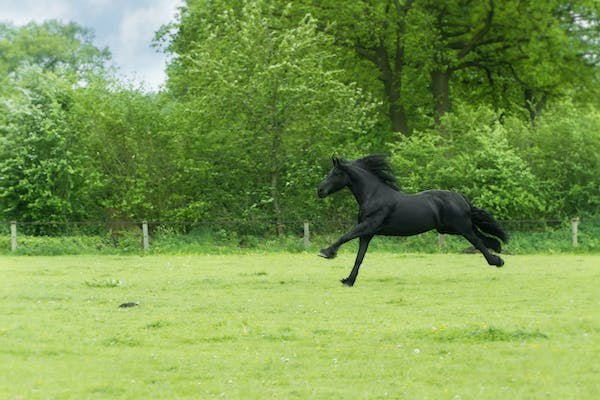

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


'the horse running through the middle of the middle of the middle of the middle of the middle '

In [ ]:
# Loading URLs
url = "https://images.pexels.com/photos/101667/pexels-photo-101667.jpeg?auto=compress&cs=tinysrgb&w=600"

# Display Image
display(load_image(url))

# Display Caption
get_caption(model, image_processor, tokenizer, url)

*Example 2.*

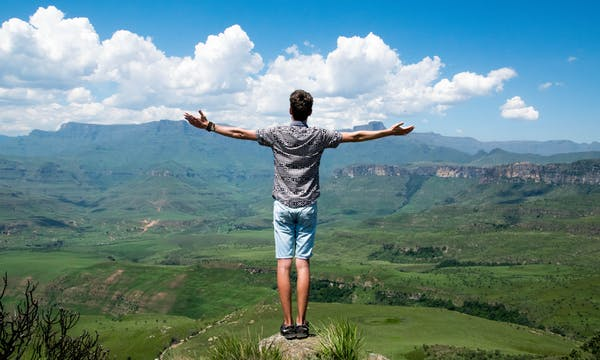

'a composite of a figure of a top of a slope '

In [ ]:
# Loading URLs
url = "https://images.pexels.com/photos/103123/pexels-photo-103123.jpeg?auto=compress&cs=tinysrgb&w=600"

# Display Image
display(load_image(url))

# Display Caption
get_caption(model, image_processor, tokenizer, url)

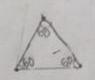

'sketch of a triangle with triangle with triangle with triangle with triangle with with with with with'

In [ ]:
# Loading URLs
url = "/content/image-name.jpg"

# Display Image
display(load_image(url))

# Display Caption
get_caption(model, image_processor, tokenizer, url)